In [253]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Ignore matplotlib warnings
import warnings
warnings.filterwarnings("ignore")

In [254]:
import json

tweet_files = ['C:/Users/abhin/Documents/3_Spring Classes/Social Media/Project/twitter_search/#FinalStrike/#FinalStrike_2019-02-25_to_2019-03-03.json']
tweets = []
for file in tweet_files:
    with open(file, 'r') as f:
        for line in f.readlines():
            tweets.append(json.loads(line))

In [255]:
def populate_tweet_df(tweets):
    df = pd.DataFrame()
 
    df['text'] = list(map(lambda tweet: tweet['text'], tweets))
 
    df['location'] = list(map(lambda tweet: tweet['user']['location'], tweets))
 
    df['country_code'] = list(map(lambda tweet: tweet['place']['country_code']
                                  if tweet['place'] != None else '', tweets))
 
    df['long'] = list(map(lambda tweet: tweet['coordinates']['coordinates'][0]
                        if tweet['coordinates'] != None else 'NaN', tweets))
 
    df['latt'] = list(map(lambda tweet: tweet['coordinates']['coordinates'][1]
                        if tweet['coordinates'] != None else 'NaN', tweets))
    
    df['screen_name'] = list(map(lambda tweet: tweet['user']['screen_name'], tweets))
    
    df['created_at']  = list(map(lambda tweet: tweet['created_at'], tweets))
    
    df['followers'] = list(map(lambda tweet: tweet['user']['followers_count'], tweets))
 
    return df

In [273]:
df = populate_tweet_df(tweets)
df.head()

text            location  \
0  #onpoint #iaf #PulwamaAttack  #IndianAirForce ...               india   
1  Pakistani army again targeted India's posts &a...                       
2  RT @BhittaniKhannnn: This is heart wrenching. ...  Lyallpur, Pakistan   
3  प्रधानमंत्री @narendramodi  रोज़ अपनी “शौर्य” ...    Ahmedabad, India   
4  RT @BhittaniKhannnn: This is heart wrenching. ...      لاہور, پاکستان   

  country_code long latt      screen_name                      created_at  \
0               NaN  NaN  SIDDHARTH200419  Sun Mar 03 21:53:31 +0000 2019   
1               NaN  NaN         as_10822  Sun Mar 03 21:36:34 +0000 2019   
2               NaN  NaN   OmerAliBhatti1  Sun Mar 03 21:36:26 +0000 2019   
3               NaN  NaN    RohitSuthar73  Sun Mar 03 21:31:34 +0000 2019   
4               NaN  NaN     MUsamaNazir2  Sun Mar 03 21:28:24 +0000 2019   

   followers  
0          5  
1        242  
2         46  
3        271  
4          1

In [274]:
def find_location(df):
    df['country'] = np.where(df.location.notna(), df.location.apply(lambda x: str(x).split(',')[-1].strip().lower()),'No location')
    df['urdu'] = df.text.apply(lambda x: len(re.findall(r'[\u0600-\u06ff]+',x))>0)
    df.loc[df.urdu==1,'country'] = 'pakistan' 
    df['devanagari'] = df.text.apply(lambda x: len(re.findall(r'[\u0900-\u097f]+',x))>0)
    df.loc[df.devanagari==1,'country'] = 'india'
   
    df['pak_present'] = df.country.apply(lambda x: len(re.findall(r'pakistan',x))>0)
    df.loc[df.pak_present==1,'country'] = 'pakistan' 
    df['ind_present'] = df.country.apply(lambda x: len(re.findall(r'india',x))>0)
    df.loc[df.ind_present==1,'country'] = 'india'
    
    return df

In [275]:
def get_mentions_sent(y):
    if len(y)>0:
        return(len(y)-1)
    else:
        return(0)
df['retweeted_user']=df.text.apply(lambda x:re.findall(r'\s@(\w+):',x))
df['mentioned_user']= df.text.apply(lambda x:re.findall(r'\s@(\w+)',x))
df['mentions_sent'] = df.mentioned_user.apply(get_mentions_sent)
df['retweets_sent'] = df.retweeted_user.apply(lambda x: len(x))
df['retweeted_user']=df.text.apply(lambda x:''.join(re.findall(r'\s@(\w+):',x)))

In [276]:
find_location(df)
df.head()

text            location  \
0  #onpoint #iaf #PulwamaAttack  #IndianAirForce ...               india   
1  Pakistani army again targeted India's posts &a...                       
2  RT @BhittaniKhannnn: This is heart wrenching. ...  Lyallpur, Pakistan   
3  प्रधानमंत्री @narendramodi  रोज़ अपनी “शौर्य” ...    Ahmedabad, India   
4  RT @BhittaniKhannnn: This is heart wrenching. ...      لاہور, پاکستان   

  country_code long latt      screen_name                      created_at  \
0               NaN  NaN  SIDDHARTH200419  Sun Mar 03 21:53:31 +0000 2019   
1               NaN  NaN         as_10822  Sun Mar 03 21:36:34 +0000 2019   
2               NaN  NaN   OmerAliBhatti1  Sun Mar 03 21:36:26 +0000 2019   
3               NaN  NaN    RohitSuthar73  Sun Mar 03 21:31:34 +0000 2019   
4               NaN  NaN     MUsamaNazir2  Sun Mar 03 21:28:24 +0000 2019   

   followers   retweeted_user     mentioned_user  mentions_sent  \
0          5                                  []              0   
1        242                      [ImranKhanPTI]              0   
2         46  BhittaniKhannnn  [BhittaniKhannnn]              0   
3        271                      [narendramodi]              0   
4          1  BhittaniKhannnn  [BhittaniKhannnn]              0   

   retweets_sent   country   urdu  devanagari  pak_present  ind_present  
0              0     india  False       False        False         True  
1              0            False       False        False        False  
2              1  pakistan  False       False         True        False  
3              0     india  False        True        False         True  
4              1   پاکستان  False       False        False        False

In [277]:
df = df[df['retweets_sent']>0]
df.shape

(29971, 17)

## India Network for Final Strike

In [288]:
ind_list = ['भारत','mumbai','delhi','new delhi','bangalore','pune','jammu and kashmir','maharashtra','bharat','भारत गणराज्य',
           'chennai','kolkatta','kashmir','nagpur','hyderabad','kolkata','hindustan','हिन्दुस्तान 🇮🇳','bengaluru','gujarat',
           'karnataka','navi mumbai','gurgaon','lucknow','thane','rajasthan','west bengal','noida','punjab']
pak_list = ['islamabad','karachi','lahore','پاکستان','hyderbad','پاکستان']

In [289]:
df.country.replace(to_replace=ind_list, value='india', regex=True,inplace=True)
df.country.replace(to_replace=pak_list, value='pakistan', regex=True,inplace=True)

In [290]:
df.head(100)

text  \
2    RT @BhittaniKhannnn: This is heart wrenching. ...   
4    RT @BhittaniKhannnn: This is heart wrenching. ...   
5    RT @HinaKharal: پاکستان سے دھلائی کے بعد بھارت...   
6    RT @BhittaniKhannnn: This is heart wrenching. ...   
15   RT @prasadchaubal: @samirsinh189 @PMOIndia @na...   
17   RT @advsarang: @samirsinh189 Absolutely well s...   
18   RT @KetansinhS: @samirsinh189 #FinalStrike is ...   
19   RT @nshantanu: @samirsinh189 How many soldiers...   
20   RT @Sangitavartak: @samirsinh189 Yes, It is th...   
21   RT @OfficialMehmood: Anchor:  this is part of ...   
22   RT @nshantanu: @samirsinh189 @republic @narend...   
23   RT @NBhalwankar: @samirsinh189 @republic @nare...   
24   RT @mahajan_hareesh: Want to congratulate @rep...   
25   RT @NBhalwankar: @samirsinh189 @republic @nare...   
26   RT @mihirnagarkar: No mercy must be shown to P...   
27   RT @KalpanaNaik11: @samirsinh189 @republic @na...   
28   RT @VU3SDZ: POC (Pak Occupied Indian Congress)...   
29   RT @samirsinh189: Aniruddha Bapu says "Its now...   
30   RT @NBhalwankar: It’s time for piece talks. Cu...   
31   RT @nshantanu: This is what Pakistan's peace p...   
32   RT @VU3SDZ: #TerrorTraffickerISI plans to pois...   
33   RT @leeladhar64: Pakistan has always been a tu...   
34   RT @VU3SDZ: @SobdarBaluch #FinalStrike brother...   
35   RT @abhytawde: Jammu Kashmir Kupwara Handwara ...   
36   RT @NBhalwankar: @PMOIndia Its time for #Final...   
37   RT @jigs237: This time no mercy on terrorism a...   
38   RT @amit_katwankar: दुष्टों का और दानवों का सं...   
39   RT @k_pranali: Dear @PMOIndia, let's not wait ...   
40   RT @Nivassinh: काटे थे शीश जवानो के तो इसका हश...   
41   RT @VU3UJM: #FinalStrike on #Pakistan\n#JaishE...   
..                                                 ...   
121  RT @CAVishnuSharma: आपकी 400 "वोट" कम हो गईl ब...   
125  RT @RaiSahab20: देश में बैठे देशबेचवा @INCIndi...   
127  RT @samirsinh189: Aniruddha Bapu says "Its now...   
132  RT @trollsangh: Modi you cannot rule this coun...   
133  RT @KetansinhS: झाडाजवळचे नको असलेले 'तण' उपटू...   
134  RT @VU3SDZ: #TerrorTraffickerISI plans to pois...   
135  RT @shwetajaitapkar: .@NewscastGlobal   #Final...   
136  RT @SumietsinhS: @Shehzad58708684 @RoshansinhZ...   
137  RT @sarcasticreal10: After descending from Par...   
139  RT @Dr_SimranSingh: एक हमारे जाबांज कमाण्डर अभ...   
141  RT @VU3SDZ: POC (Pak Occupied Indian Congress)...   
142  RT @k_pranali: Dear @PMOIndia, let's not wait ...   
143  RT @k_pranali: #TerrorStatePakistan stoops to ...   
144  RT @hemant2025: Pakistan is a #cancer and only...   
145  RT @abhytawde: भारतमाता की जय । भारत के वीर जव...   
146  RT @VU2XDB: .@narendramodi every passing day w...   
149  RT @as_10822: People who are dreaming &amp; de...   
150  RT @hemant2025: Pakistan is a #cancer and only...   
151  RT @vaibhavsinh: See how our brave soldiers r ...   
153  RT @Nivassinh: @samirsinh189 If India is attac...   
154  RT @Nivassinh: Why India is always at the rece...   
155  RT @VU3SDZ: POC (Pak Occupied Indian Congress)...   
156  RT @Nivassinh: #FinalStrike https://t.co/Ov0HF...   
158  RT @Nivassinh: काटे थे शीश जवानो के तो इसका हश...   
161  RT @k_pranali: Dear @PMOIndia, let's not wait ...   
162  RT @Nivassinh: काटे थे शीश जवानो के तो इसका हश...   
172  RT @Kiran123445: #FinalStrike\nदयानंद कहना है ...   
175  RT @Kiran123445: #FinalStrike\nदयानंद कहना है ...   
179  RT @k_pranali: Dear @PMOIndia, let's not wait ...   
181  RT @KetansinhS: Even if @pid_gov @ImranKhanPTI...   

                           location country_code long latt      screen_name  \
2                Lyallpur, Pakistan               NaN  NaN   OmerAliBhatti1   
4                    لاہور, پاکستان               NaN  NaN     MUsamaNazir2   
5                                                 NaN  NaN   ShahzadaHairan   
6    London, UK, Antwerpen, Belgium               NaN  NaN       RNNetwork1   
15                                                NaN  NaN

In [291]:
df = df[df.retweets_sent==1]
df.retweets_sent.value_counts()

1    29965
Name: retweets_sent, dtype: int64

In [292]:
df.to_csv("FinalStrike_cleaned.csv")

In [2]:
df = pd.read_csv("FinalStrike_cleaned.csv")

In [3]:
df_ind = df[df['country']=='india']
df_ind.shape

(12905, 18)

In [245]:
g_ind = nx.from_pandas_edgelist(df_ind, source='screen_name', target='retweeted_user'
,edge_attr = 'retweets_sent',create_using=nx.DiGraph())
pos = nx.spring_layout(g_ind)
betCent = nx.betweenness_centrality(g_ind, normalized=True, endpoints=True)

In [246]:
ti = ['SwamiGeetika','republic','DesiStupides','SirJadeja','SengarAjay505','JhaRahul_Bihar','AbidiAsfaq']

In [250]:
sorted(betCent, key=betCent.get, reverse=True)[:10]

['ReshmaNarkhede',
 'prasadchaubal',
 'DesiStupides',
 'SengarAjay505',
 'SwamiGeetika',
 'JhaRahul_Bihar',
 'republic',
 'HaftaWasooli',
 'BhavdeepPandya9',
 'VazeIndian']

In [247]:
labels = {}    
for node in g_ind.nodes():
    if node in ti:
        #set the node name as the key and the label as its value 
        labels[node] = node

In [248]:
g=g_ind

Name: 
Type: DiGraph
Number of nodes: 7180
Number of edges: 9058
Average in degree:   1.2616
Average out degree:   1.2616


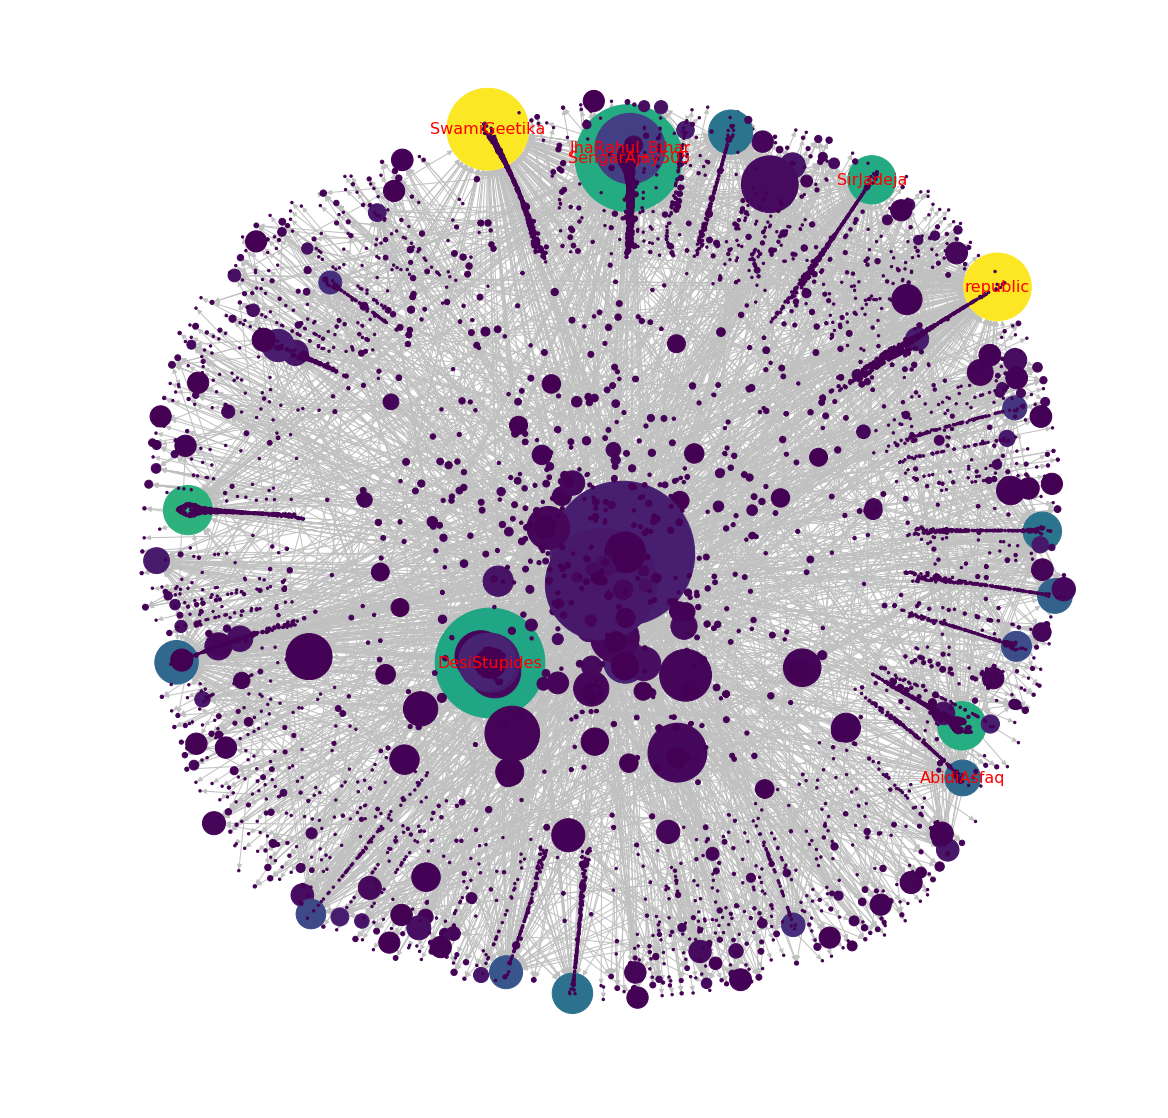

In [249]:
node_color = [20000.0 * g.degree(v) for v in g]
node_size =  [v * 3e8 for v in betCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(g, pos=pos, with_labels=None,
                 node_color=node_color,
                 node_size=node_size,edge_color = 'silver' )

nx.draw_networkx_labels(g,labels=labels,pos=pos,font_size=16,font_color='r')

plt.axis('off')
print(nx.info(g))

## Final Strike Network - Pakistan

In [23]:
df_pak = df[df['country']=='pakistan']
df_pak.shape

(3650, 18)

In [24]:
g_pak = nx.from_pandas_edgelist(df_pak, source='screen_name', target='retweeted_user'
,edge_attr = 'retweets_sent',create_using=nx.DiGraph())
pos = nx.spring_layout(g_pak)
betCent = nx.betweenness_centrality(g_pak, normalized=True, endpoints=True)

In [25]:
ti = sorted(betCent, key=betCent.get, reverse=True)[:10]
labels = {}    
for node in g_ind.nodes():
    if node in ti:
        #set the node name as the key and the label as its value 
        labels[node] = node
g=g_pak

In [27]:
ti

['BhittaniKhannnn',
 'imMAK02',
 'HinaKharal',
 'schaheid',
 'voicenewspk479',
 'da_watan_lewany',
 'DefenderPaki',
 'viitvdotcom',
 'ZahidSiddique_',
 'KhuramKTS']

Name: 
Type: DiGraph
Number of nodes: 2760
Number of edges: 3119
Average in degree:   1.1301
Average out degree:   1.1301


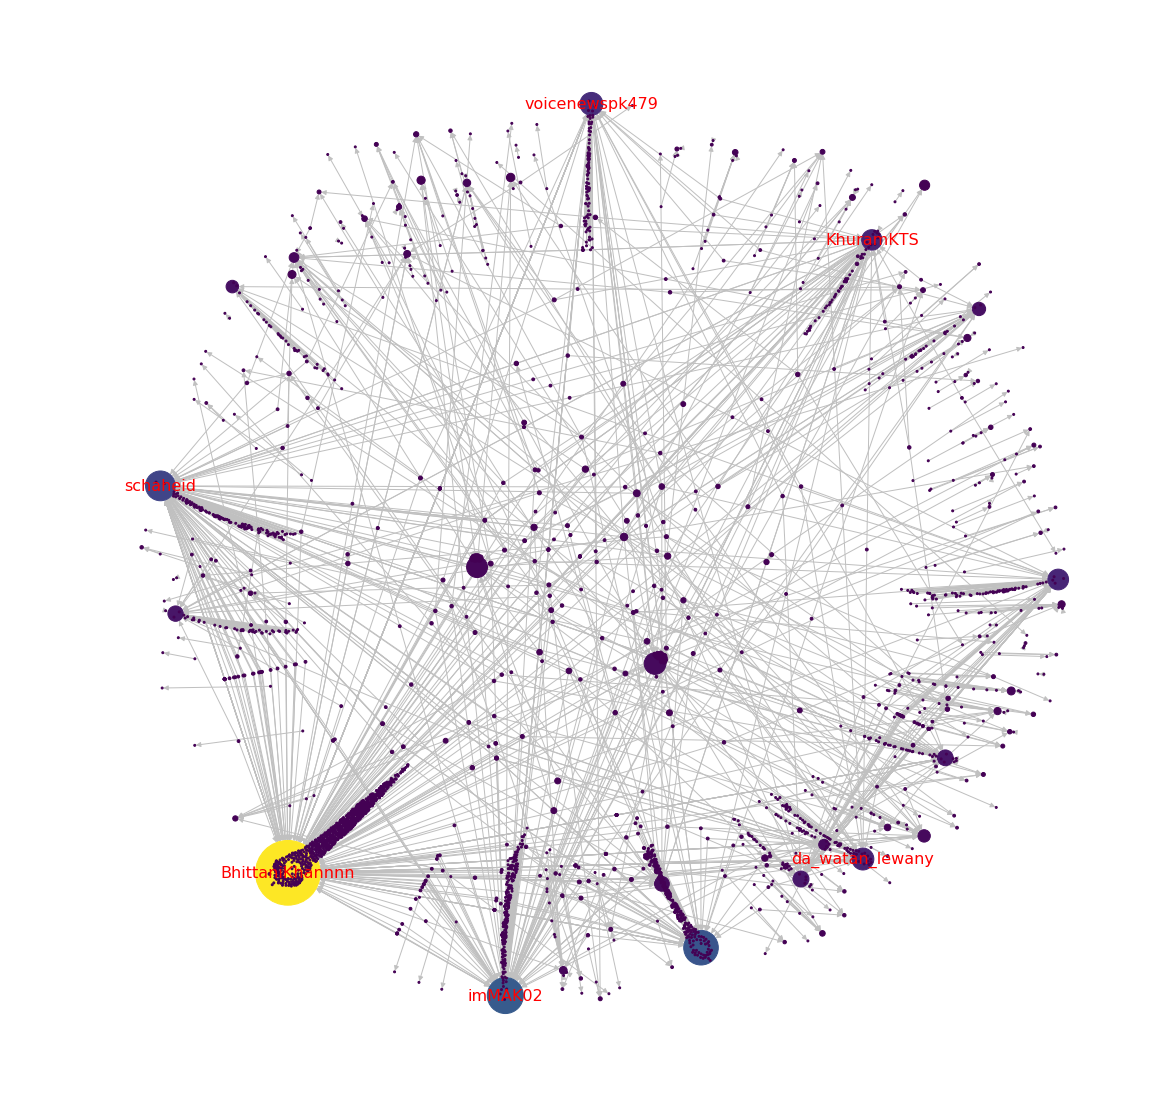

In [31]:
node_color = [20000.0 * g.degree(v) for v in g]
node_size =  [v * 3e7 for v in betCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(g, pos=pos, with_labels=None,
                 node_color=node_color,
                 node_size=node_size, edge_color = 'silver' )
nx.draw_networkx_labels(g,labels=labels,pos=pos,font_size=16,font_color='r')
plt.axis('off')
print(nx.info(g))

## Network without top 1% of betweenness

In [79]:
g = nx.from_pandas_edgelist(df_ind, source='screen_name', target='retweeted_user'
,edge_attr = 'retweets_sent',create_using=nx.DiGraph())
betCent = nx.betweenness_centrality(g)

In [84]:
 sorted(betCent, key=betCent.get, reverse=True)

['gorinanu',
 'prasadchaubal',
 'ReshmaNarkhede',
 'CJeet1989',
 'VishalDholam',
 'VU3MYX',
 'santoshsadafule',
 'SunitaBagade',
 'TruthRoars',
 'ErKavitaveera',
 'himanshupuri313',
 'indianprnk',
 'ImROOcky',
 'getazadi',
 'mukundsinghs',
 'Dr_SimranSingh',
 'ramnathjha7',
 'Sonu108Mehra',
 'bibhash1990',
 'imMAK02',
 'ramakirao',
 'Ramesh_BJP',
 'imgprajapati',
 'vikash_s_t',
 'RajatSh12551457',
 'pawan26kpareek',
 'Ssumi69',
 'MoJitendra',
 'Rinmayee_003',
 'AbidiAsfaq',
 'Abhishek13474',
 'Mridulaphukan1',
 'Amitkalraj',
 'RajeshS46893483',
 'Kiran123445',
 'meenara40192316',
 'singhdangi',
 'SwamiGeetika',
 'india',
 'SurpalsinhRath5',
 'nageenshekhawat',
 'AnandAzaad',
 'kdevashree',
 'SharadaK18',
 'samirsinh189',
 'yoyoajitsingh18',
 'republic',
 'rajeshbillore72',
 'Virajkirad1',
 'astroaptiwari',
 'leoarnyravi',
 'chote_millu144',
 'AdityaDaksha1',
 'dranjaliswami',
 'evilenuff',
 'pradeepksm2272',
 'SKS959',
 'JhaRahul_Bihar',
 'Arifmir1',
 'BhittaniKhannnn',
 'prakashSriv',

In [85]:
top_influencers = sorted(betCent, key=betCent.get, reverse=True)[:50]
df3 = df[-df['screen_name'].isin(top_influencers)]
df3.shape

(3797, 22)

(-1.0690620183944701,
 1.1077184915542602,
 -1.189561525285244,
 0.9949093851447106)

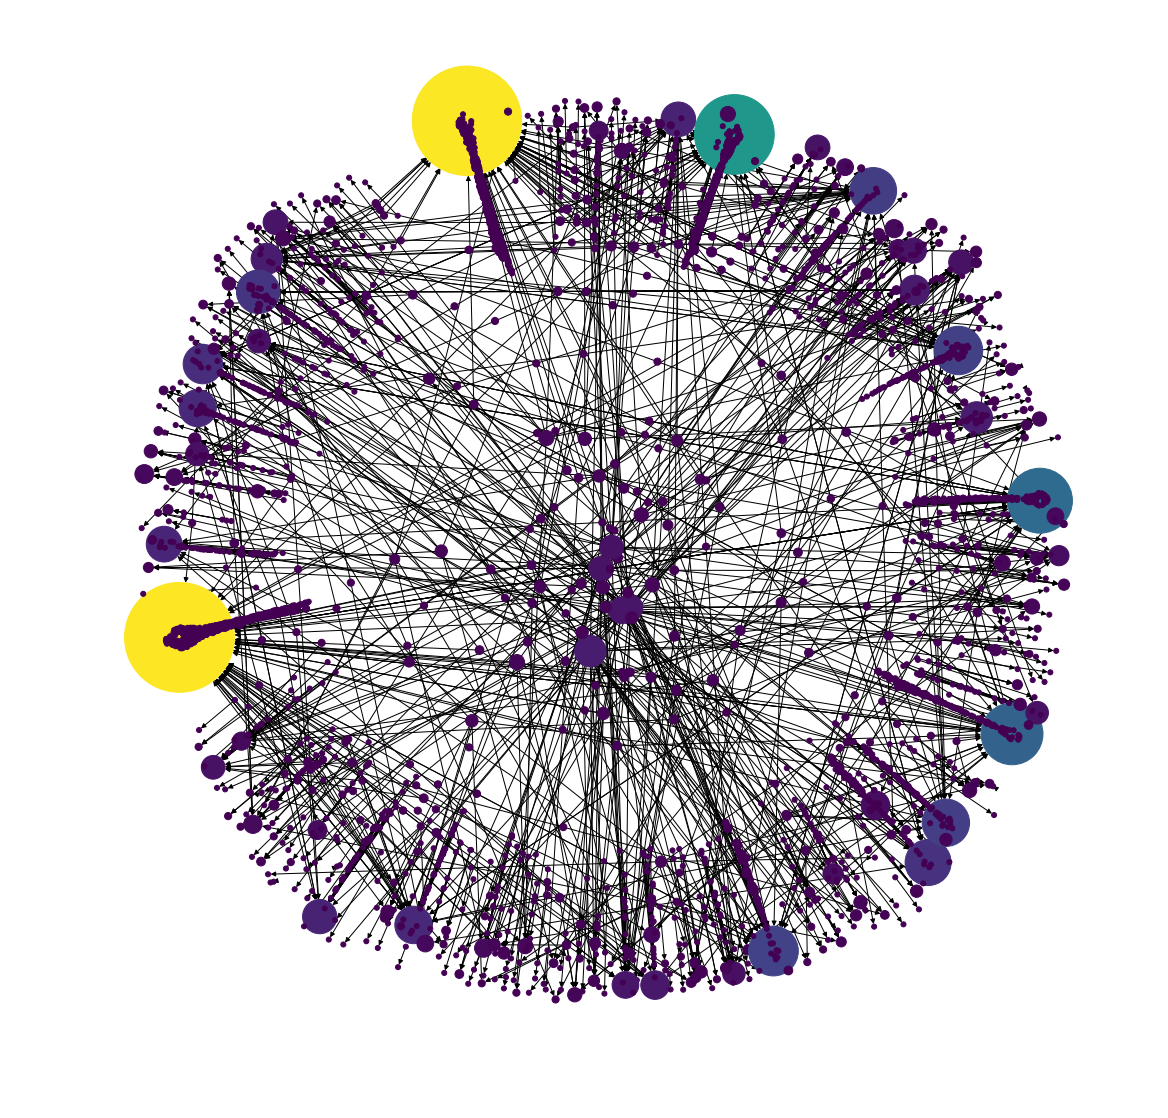

In [87]:
G = nx.from_pandas_edgelist(df3, source='screen_name', target='retweeted_user'
,edge_attr = 'retweets_sent',create_using=nx.DiGraph())
pos = nx.spring_layout(G)
betCent = nx.betweenness_centrality(G, normalized=True, endpoints=True)
node_color = [20000.0 * G.degree(v) for v in G]
node_size =  [v * 3e8 for v in betCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(G, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

## Network without top 10% of degree

In [13]:
degreeCent = nx.degree_centrality(g)
top_influencers = sorted(degreeCent, key=degreeCent.get, reverse=True)[:400]
df3 = df[-df['screen_name'].isin(top_influencers)]
df3.shape

(3919, 17)

(-1.1703651618957518,
 1.0585206222534178,
 -1.0331466218829155,
 1.1931949278712273)

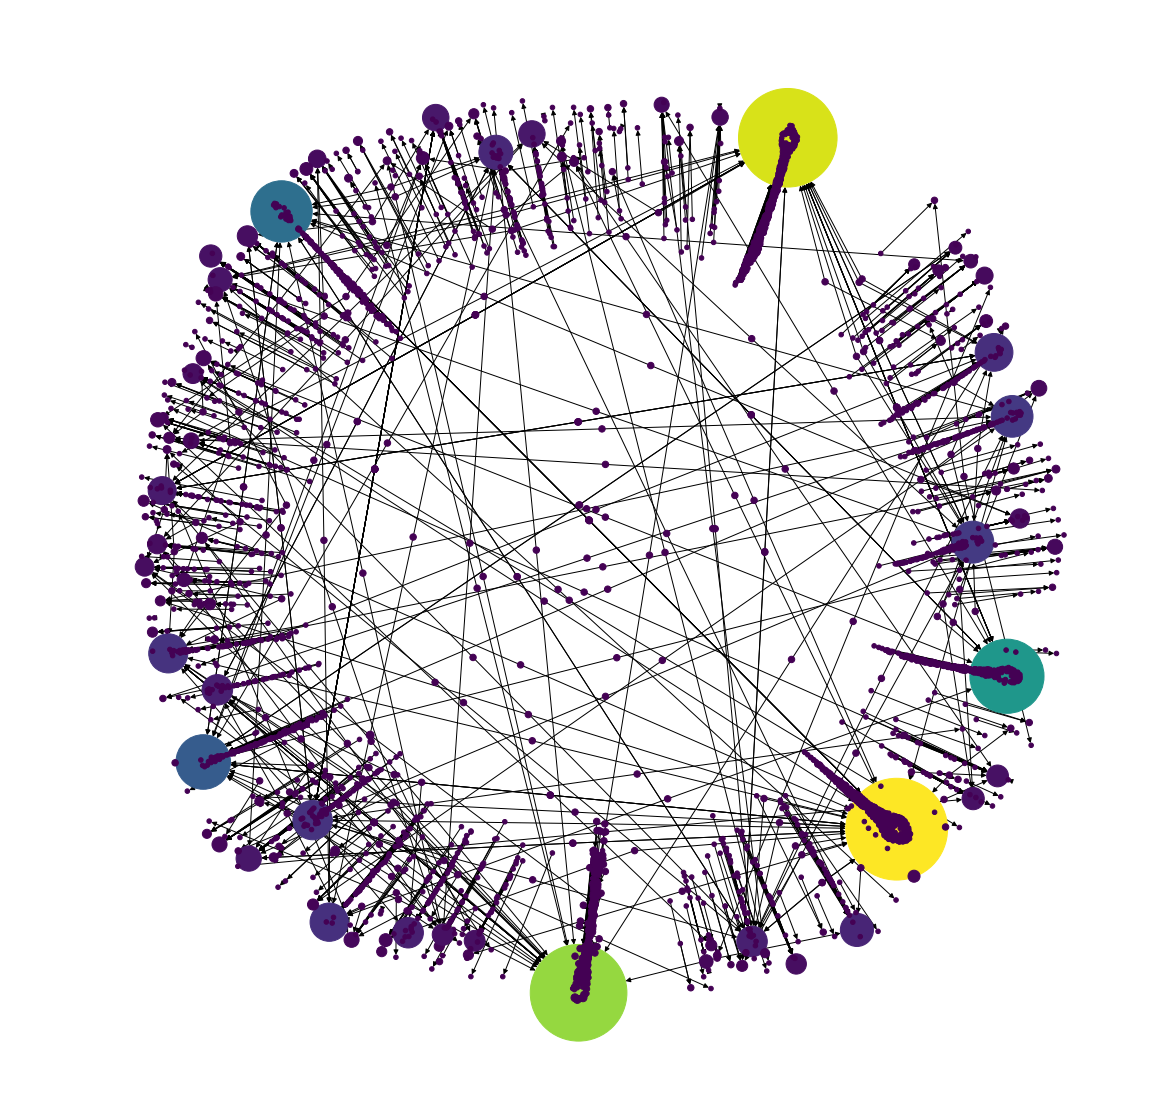

In [14]:
G = nx.from_pandas_edgelist(df3, source='screen_name', target='retweeted_user'
,edge_attr = 'retweets_sent',create_using=nx.DiGraph())
pos = nx.spring_layout(G)
betCent = nx.betweenness_centrality(G, normalized=True, endpoints=True)
node_color = [20000.0 * G.degree(v) for v in G]
node_size =  [v * 3e8 for v in betCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(G, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

## Network without top 1% closeness

In [25]:
closeCent = nx.closeness_centrality(g)
top_influencers = sorted(closeCent, key=closeCent.get, reverse=True)[:400]
df3 = df[-df['screen_name'].isin(top_influencers)]
df3.shape

(4069, 17)

Name: 
Type: DiGraph
Number of nodes: 4081
Number of edges: 4595
Average in degree:   1.1259
Average out degree:   1.1259


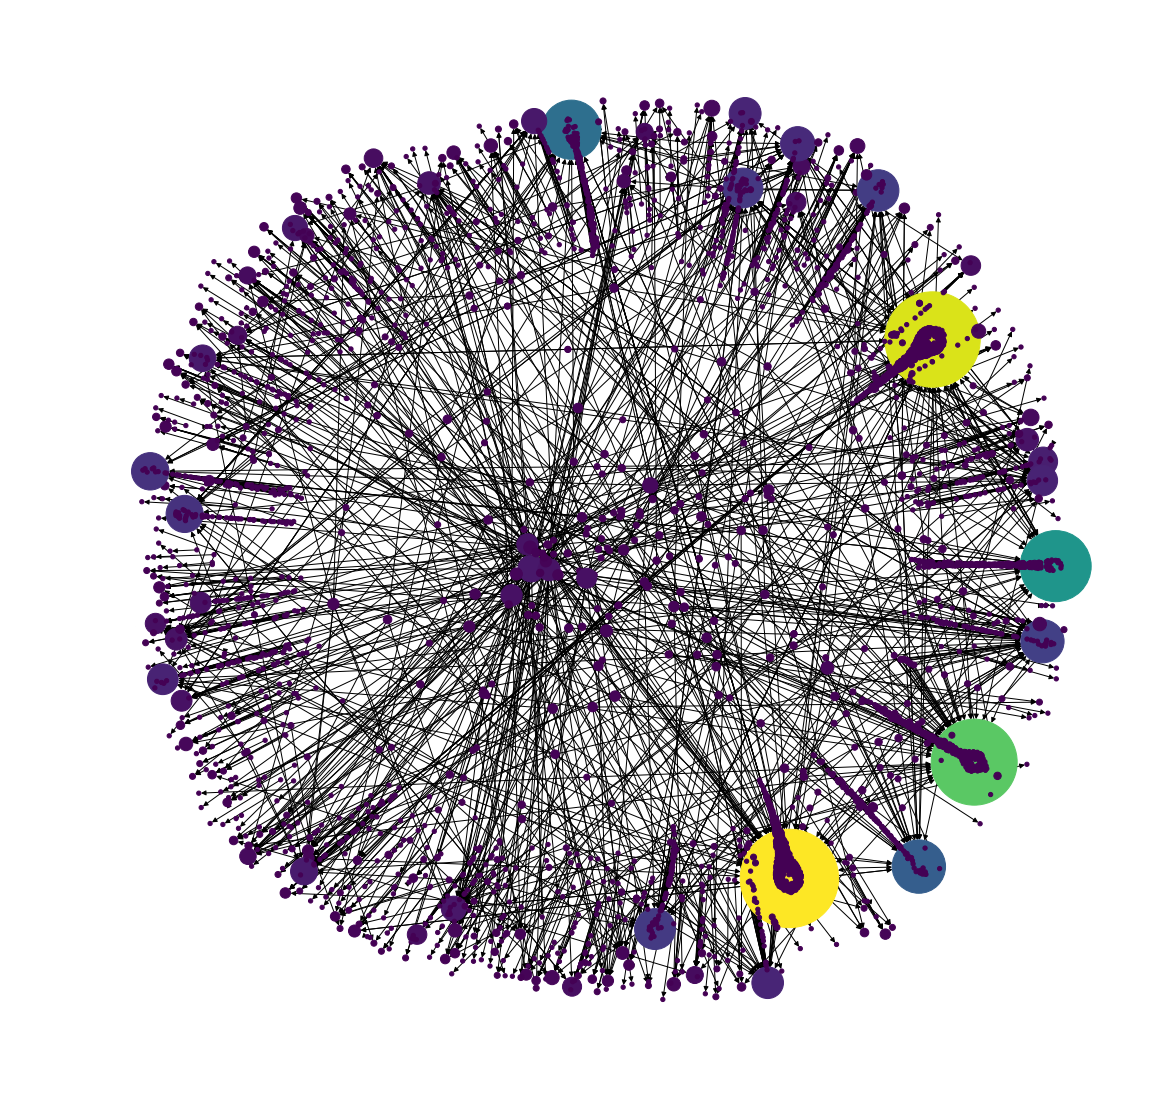

In [16]:
G = nx.from_pandas_edgelist(df3, source='screen_name', target='retweeted_user'
,edge_attr = 'retweets_sent',create_using=nx.DiGraph())
pos = nx.spring_layout(G)
closeCent = nx.closeness_centrality(G, normalized=True, endpoints=True)
node_color = [20000.0 * G.degree(v) for v in G]
node_size =  [v * 3e8 for v in closeCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(G, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')
print(nx.info(g))

## Network attributes of users with top 1% of betweenness

In [32]:
degree = pd.DataFrame(nx.degree_centrality(g),index=['degree']).T.reset_index()
closeness = pd.DataFrame(nx.closeness_centrality(g),index=['closeness']).T.reset_index() #important for influencer
betweenness = pd.DataFrame(nx.betweenness_centrality(g),index=['betweenness']).T.reset_index()
df_m1 = df.groupby(['screen_name'])['mentions_sent','retweets_sent'].sum()
df_m2 = df.drop_duplicates(['screen_name'])[['screen_name','followers']]
df_m3 = pd.merge(df_m1,df_m2,how='inner',on='screen_name')
measures = degree.merge(closeness,on='index').merge(betweenness,on='index')
df_m4 = pd.merge(df_m3,measures,how='inner',left_on='screen_name',right_on = 'index')
df_m4.head()

screen_name  mentions_sent  retweets_sent  followers          index  \
0     0yee_h0yee              0              1       2524     0yee_h0yee   
1      12456ggxh              0              1         14      12456ggxh   
2  12surajsharma              0              1         88  12surajsharma   
3   1349Himanshu              0              1         59   1349Himanshu   
4       192119AB              0              0         27       192119AB   

     degree  closeness  betweenness  
0  0.000245        0.0          0.0  
1  0.000245        0.0          0.0  
2  0.000245        0.0          0.0  
3  0.000245        0.0          0.0  
4  0.000245        0.0          0.0

In [39]:
df_m4['betweenness_decile'] = df_m4['betweenness'].rank()
df_m4['closeness_decline'] = df_m4['closeness'].rank()
df_m4['degree_decile'] = df_m4['degree'].rank()

In [45]:
df_m4.groupby(['betweenness_decile'])[['betweenness','mentions_sent','retweets_sent','followers']].mean().sort_values(by='betweenness_decile',ascending=False)

betweenness  mentions_sent  retweets_sent     followers
betweenness_decile                                                          
3839.0              5.437944e-06       0.000000       0.000000  2.040300e+04
3838.0              2.764038e-06      25.000000      22.000000  1.691000e+03
3837.0              2.163160e-06       1.000000       1.000000  3.449000e+03
3836.0              1.442107e-06       0.000000       0.000000  3.940800e+04
3834.5              1.261843e-06       4.500000       3.000000  2.111950e+04
3833.0              8.412289e-07       0.000000       0.000000  2.873000e+03
3832.0              6.609655e-07       0.000000       0.000000  1.258247e+06
3830.5              6.008778e-07       0.000000       0.500000  1.137400e+04
3828.0              4.807022e-07       1.666667       2.666667  4.976667e+03
3825.5              4.206144e-07       0.000000       1.000000  2.033400e+04
3824.0              3.810111e-07       0.000000       0.000000  1.635000e+03
3822.0              3.605267e-07       5.666667       0.333333  3.332333e+03
3820.0              3.304828e-07       9.000000       0.000000  1.696000e+03
3817.5              3.004389e-07       1.250000       0.250000  7.403250e+03
3815.0              2.553730e-07       1.000000       1.000000  1.070000e+02
3812.0              2.403511e-07       0.000000       0.600000  2.557800e+03
3807.5              1.802633e-07       0.000000       1.250000  3.019750e+03
3805.0              1.556820e-07     115.000000       0.000000  1.816000e+03
3804.0              1.502194e-07       0.000000       3.000000  4.535000e+03
3802.0              1.351975e-07       0.000000       0.000000  5.566667e+02
3800.0              1.285211e-07       6.000000       1.000000  1.200000e+01
3799.0              1.273072e-07       6.000000       1.000000  1.200000e+02
3788.0              1.201756e-07       0.238095       0.333333  2.449190e+03
3777.0              9.726329e-08      25.000000       0.000000  2.576000e+03
3775.0              9.013166e-08       0.000000       0.333333  1.183517e+05
3773.0              8.178614e-08       6.000000       0.000000  3.700000e+01
3771.0              8.011703e-08       0.000000       0.333333  3.441667e+03
3767.5              7.510972e-08       0.250000       0.000000  2.732500e+02
3765.0              6.843330e-08       6.000000       2.000000  1.210000e+02
3763.5              6.555030e-08       1.000000       0.000000  3.940000e+02
3760.0              6.175688e-08       7.600000       0.600000  1.732000e+02
3729.5              6.008778e-08       0.785714       0.160714  1.205196e+03
3701.0              3.838941e-08       6.000000       1.000000  1.700000e+01
3699.5              3.004389e-08       0.500000       0.500000  1.015000e+02
3696.0              2.002926e-08       0.000000       0.000000  1.756000e+02
3693.0              1.502194e-08       0.000000       0.000000  0.000000e+00
3689.5              8.345524e-09       6.000000       1.000000  7.250000e+01
3686.0              7.131630e-09       6.000000       0.000000  4.840000e+02
3683.5              5.462525e-09       2.500000       0.250000  2.417500e+02
3672.5              1.669105e-09       6.000000       0.000000  7.305556e+01
1832.0              0.000000e+00       0.376194       1.112203  1.542522e+03

In [46]:
df_m4.groupby(['closeness_decline'])[['closeness','mentions_sent','retweets_sent','followers']].mean().sort_values(by='closeness_decline',ascending=False)

closeness  mentions_sent  retweets_sent     followers
closeness_decline                                                       
3839.0              0.047799       0.000000       1.000000  7.777000e+03
3838.0              0.022549       0.000000       0.000000  2.040300e+04
3837.0              0.006373       0.000000       1.000000  3.122000e+03
3836.0              0.005882       0.000000       0.000000  3.940800e+04
3835.0              0.005147       0.000000       0.000000  4.114600e+04
3834.0              0.004902       1.000000       1.000000  3.170000e+02
3833.0              0.004669       1.000000       1.000000  3.449000e+03
3832.0              0.002826       0.000000       0.000000  2.873000e+03
3831.0              0.002761       0.000000       0.000000  1.635000e+03
3830.0              0.002696       0.000000       0.000000  1.258247e+06
3828.5              0.002451       0.000000       0.500000  1.137400e+04
3827.0              0.002206     115.000000       0.000000  1.816000e+03
3826.0              0.001961       0.000000       0.000000  5.745000e+03
3824.5              0.001716       0.000000       0.500000  1.891700e+04
3823.0              0.001654      25.000000       0.000000  2.576000e+03
3822.0              0.001501       5.000000       1.000000  1.809300e+04
3820.0              0.001471       8.333333       0.000000  1.917000e+03
3818.0              0.001261       0.000000       0.000000  2.933000e+03
3816.0              0.001225       0.000000       0.000000  3.840000e+03
3814.0              0.001021       6.000000       0.000000  3.700000e+01
3813.0              0.001001       5.000000       2.000000  6.030000e+03
3809.5              0.000980       0.000000       0.500000  3.639500e+03
3806.0              0.000784       1.000000       0.000000  2.510000e+02
3799.5              0.000735       2.000000       1.000000  2.725833e+03
3792.5              0.000654       3.500000       0.500000  1.355000e+02
3790.0              0.000551       0.000000       0.000000  5.073333e+02
3771.5              0.000490       1.882353       0.764706  1.212718e+04
3752.0              0.000441       0.800000       0.400000  3.866000e+02
3748.0              0.000327       0.333333       0.000000  2.473333e+02
3689.0              0.000245       1.956522       0.373913  6.958000e+02
1816.0              0.000000       0.375103       1.119802  1.548334e+03

In [48]:
df_m4.groupby(['degree_decile'])[['degree','mentions_sent','retweets_sent','followers']].mean().sort_values(by='degree_decile',ascending=False)

degree  mentions_sent  retweets_sent      followers
degree_decile                                                       
3839.0         0.048284       0.000000       1.000000    7777.000000
3838.0         0.022794       0.000000       0.000000   20403.000000
3837.0         0.008824     348.000000      38.000000    2312.000000
3836.0         0.006863       0.000000       1.000000    3122.000000
3834.5         0.006618      21.000000      28.500000      13.000000
3832.5         0.006127      12.500000      11.000000   20549.500000
3831.0         0.005882      70.000000      35.000000    3848.000000
3829.0         0.005392       1.666667      13.000000   13849.666667
3827.0         0.005147       1.000000       1.000000    3449.000000
3825.5         0.003186       1.000000       7.500000   10783.000000
3823.0         0.002941       0.000000       0.000000  420918.333333
3820.5         0.002696       1.500000       6.000000     810.500000
3819.0         0.002451       9.000000       6.000000    1093.000000
3816.0         0.002206      25.200000       4.400000    1987.800000
3812.0         0.001961       1.000000       5.333333   12768.333333
3806.5         0.001716       7.625000       2.625000    3349.625000
3796.0         0.001471       1.923077       3.230769    2599.076923
3779.5         0.001225       1.950000       2.700000    1306.750000
3752.0         0.000980       1.885714       2.371429    1811.714286
3678.5         0.000735       1.767857       1.687500    5183.089286
3443.0         0.000490       0.863510       1.406685    1340.913649
1632.0         0.000245       0.164879       0.920319    1531.161508

In [229]:
df_ind[-df_ind['screen_name'].isin(remove_li) | -df_ind['retweeted_user'].isin(remove_li)].shape

(12895, 18)

In [230]:
remove_li = ['SwamiGeetika','republic','DesiStupides','SirJadeja','SengarAjay505','JhaRahul_Bihar','AbidiAsfaq']
df_ind_sub = df_ind[-df_ind['screen_name'].isin(remove_li)]
df_ind_sub = df_ind_sub[-df_ind_sub['retweeted_user'].isin(remove_li)]
df_ind_sub.shape

(9520, 18)

Name: 
Type: DiGraph
Number of nodes: 217
Number of edges: 190
Average in degree:   0.8756
Average out degree:   0.8756


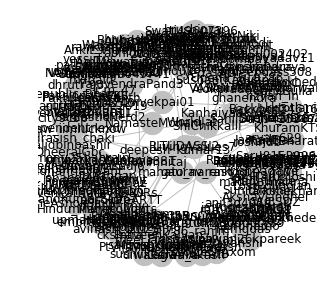

In [241]:
india_first500 = df_ind_sub.sort_values(by = ['created_at'])[:100]
g = nx.from_pandas_edgelist(india_first500, source='screen_name', target='retweeted_user'
                            ,edge_attr = 'retweets_sent',create_using=nx.DiGraph())
pos = nx.spring_layout(g)
node_color = [20000.0 * g.degree(v) for v in g]
#node_size =  [v *  for v in betCent.values()]
plt.figure(figsize=(5,5))
nx.draw_networkx(g, pos=pos, with_labels=g.node(),
                 node_color='silver',
                 node_size=500, edge_color = 'silver' )
#nx.draw_networkx_labels(g,pos=pos,font_size=16,font_color='r',labels = g.node())
plt.axis('off')
print(nx.info(g))

In [222]:
india_first500 = df_pak.sort_values(by = ['created_at'])[:2000]

g = nx.from_pandas_edgelist(india_first500, source='screen_name', target='retweeted_user'
                            ,edge_attr = 'retweets_sent',create_using=nx.DiGraph())
betCent = nx.betweenness_centrality(g, normalized=True, endpoints=True)

ti = sorted(betCent, key=betCent.get, reverse=True)[:20]

NameError: name 'TI' is not defined

In [223]:
ti

['BhittaniKhannnn',
 'HinaKharal',
 'schaheid',
 'imMAK02',
 'ZahidSiddique_',
 'voicenewspk479',
 'da_watan_lewany',
 'Independentnexu',
 'viitvdotcom',
 'ZainiMsm',
 'KhuramKTS',
 'sofiahashmi0',
 'KhanzadiFaryal',
 'mXsood',
 'afsheen_arshad',
 'OfficialMehmood',
 'DefenderPaki',
 'AnjumKiani',
 'Dawn_News',
 'kmalikk']

Name: 
Type: DiGraph
Number of nodes: 217
Number of edges: 190
Average in degree:   0.8756
Average out degree:   0.8756


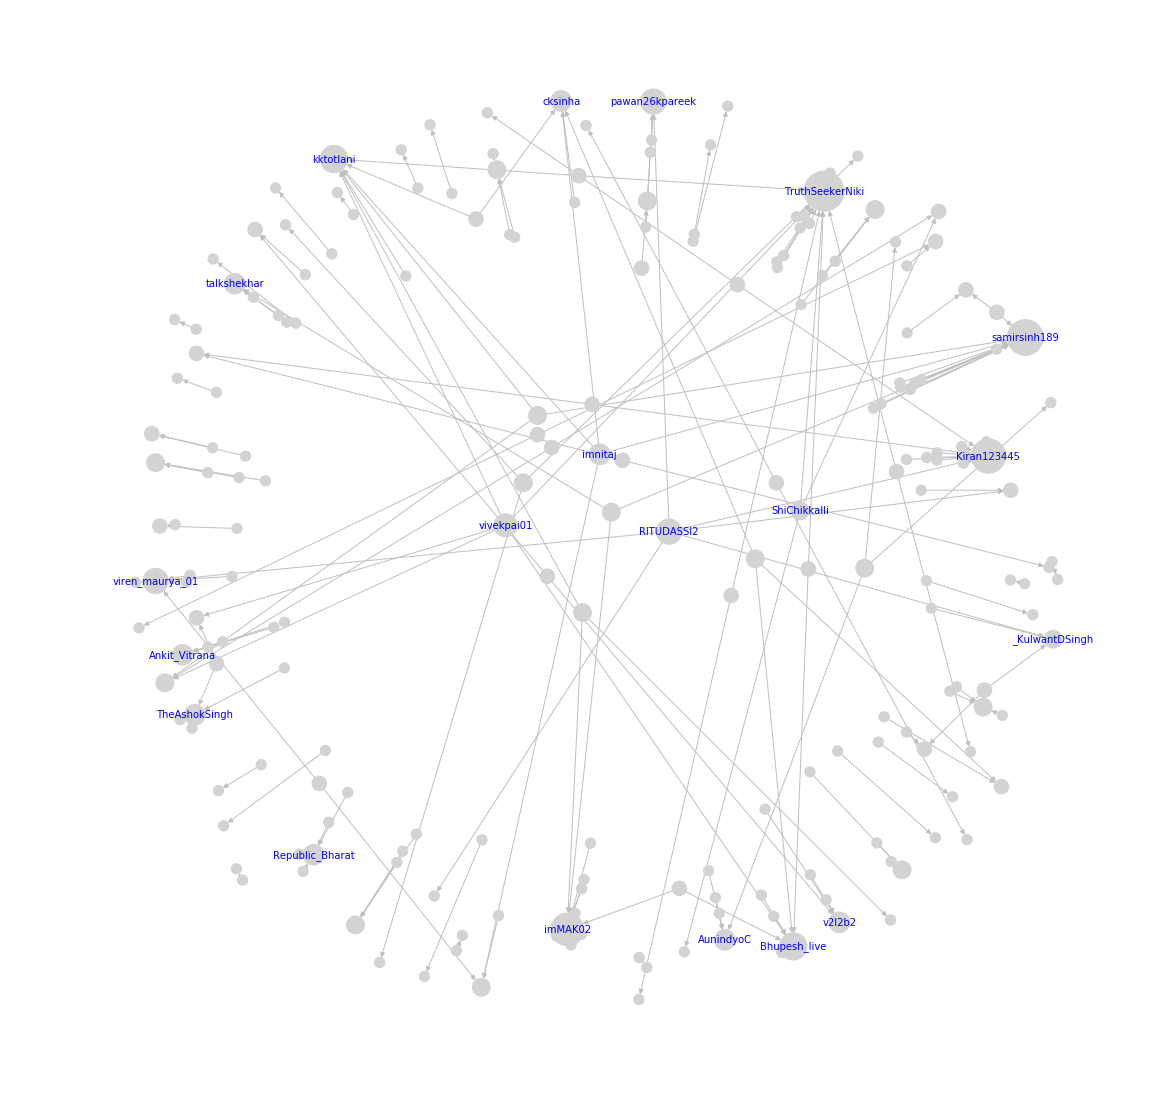

In [244]:
india_first500 = india_first500.sort_values(by = ['created_at'])[:2000]

g = nx.from_pandas_edgelist(india_first500, source='screen_name', target='retweeted_user'
                            ,edge_attr = 'retweets_sent',create_using=nx.DiGraph())
betCent = nx.betweenness_centrality(g, normalized=True, endpoints=True)

ti = sorted(betCent, key=betCent.get, reverse=True)[:20]
#ti = pd.concat([india_first500.screen_name[:20],india_first500.retweeted_user[:20] ]).unique() 
labels = {}    

for node in g.nodes():
    if node in list(ti):
        #set the node name as the key and the label as its value 
        labels[node] = node


pos = nx.spring_layout(g)
node_color = [20000.0 * g.degree(v) for v in g]
node_size =  [v * 5e6  for v in betCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(g, pos=pos, 
                 with_labels=None,
                 #node_color=node_color,
                 node_color='lightgrey',
                 node_size=node_size, edge_color = 'silver' )
nx.draw_networkx_labels(g,labels =labels,pos=pos,font_size=10,font_color='b')
plt.axis('off')
print(nx.info(g))

## Developed Network

Name: 
Type: DiGraph
Number of nodes: 5157
Number of edges: 6256
Average in degree:   1.2131
Average out degree:   1.2131


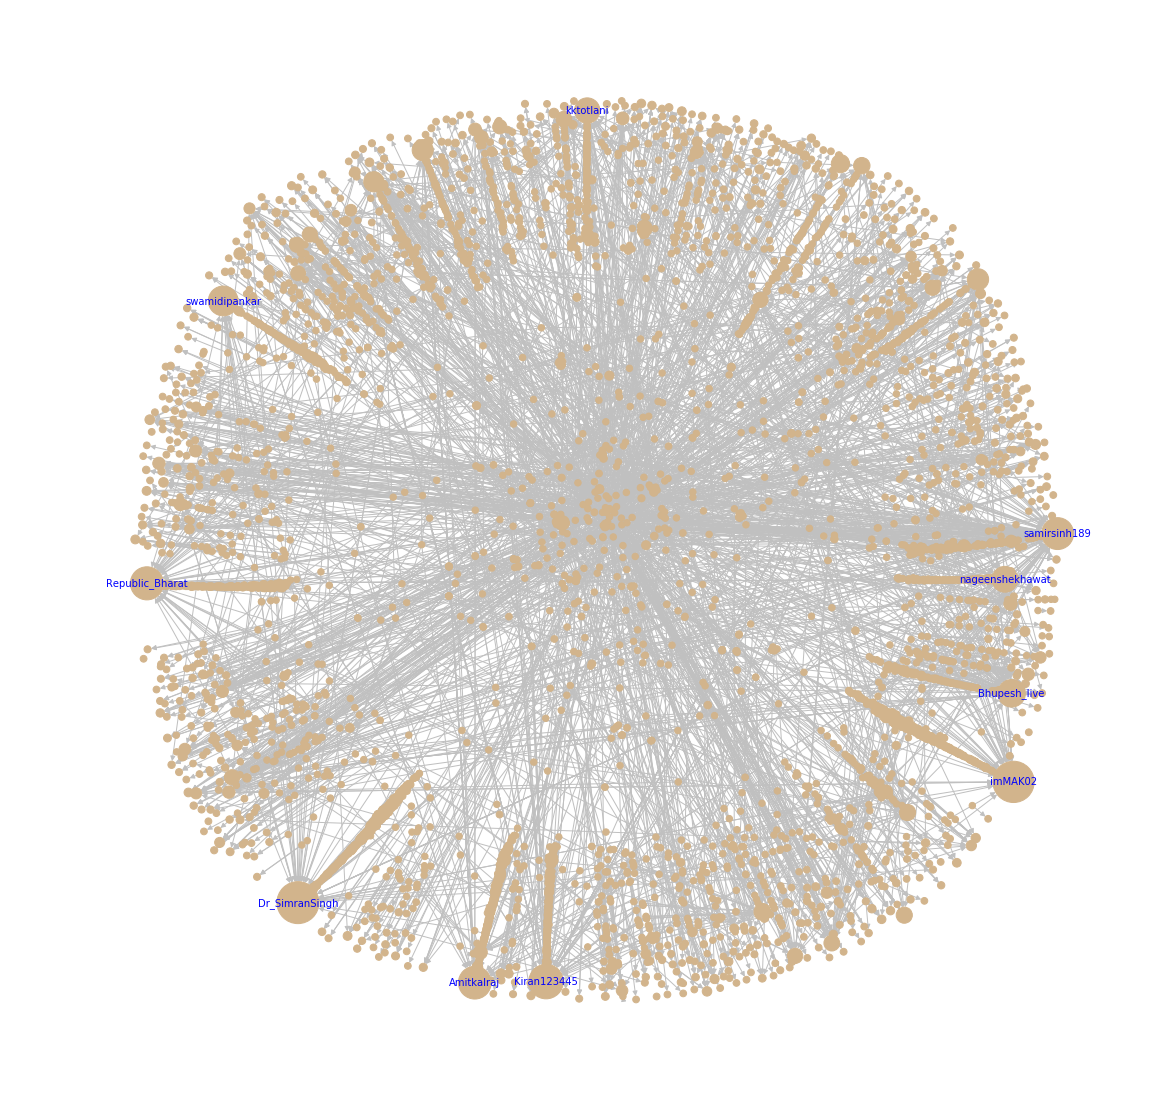

In [232]:
india_first500 = df_ind_sub

g = nx.from_pandas_edgelist(india_first500, source='screen_name', target='retweeted_user'
                            ,edge_attr = 'retweets_sent',create_using=nx.DiGraph())
betCent = nx.katz_centrality(g, normalized=True)

ti = sorted(betCent, key=betCent.get, reverse=True)[:10]
#ti = pd.concat([india_first500.screen_name[:20],india_first500.retweeted_user[:20] ]).unique() 
labels = {}    

for node in g.nodes():
    if node in list(ti):
        #set the node name as the key and the label as its value 
        labels[node] = node


pos = nx.spring_layout(g)
node_color = [20000.0 * g.degree(v) for v in g]
node_size =  [v * 5e3 for v in betCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(g, pos=pos, 
                 with_labels=None,
                 #node_color=node_color,
                 node_color='tan',
                 node_size=node_size, edge_color = 'silver' )
nx.draw_networkx_labels(g,labels =labels,pos=pos,font_size=10,font_color='b')
plt.axis('off')
print(nx.info(g))

In [221]:
ti

['BhittaniKhannnn',
 'imMAK02',
 'HinaKharal',
 'schaheid',
 'voicenewspk479',
 'ZahidSiddique_',
 'KhuramKTS',
 'da_watan_lewany',
 'ZainiMsm',
 'Independentnexu']

In [251]:
x = pd.concat([df_ind[df_ind['screen_name']=='SwamiGeetika'],df_ind[df_ind['retweeted_user']=='SwamiGeetika']])
y = pd.concat([df_ind[df_ind['screen_name']=='AbidiAsfaq'],df_ind[df_ind['retweeted_user']=='AbidiAsfaq'],
              df_ind[df_ind['screen_name']=='JhaRahul_Bihar'],df_ind[df_ind['retweeted_user']=='JhaRahul_Bihar'],
              df_ind[df_ind['screen_name']=='ReshmaNarkhede'],df_ind[df_ind['retweeted_user']=='ReshmaNarkhede']])
india_first500  = pd.concat([x,y])

Name: 
Type: DiGraph
Number of nodes: 1005
Number of edges: 1039
Average in degree:   1.0338
Average out degree:   1.0338


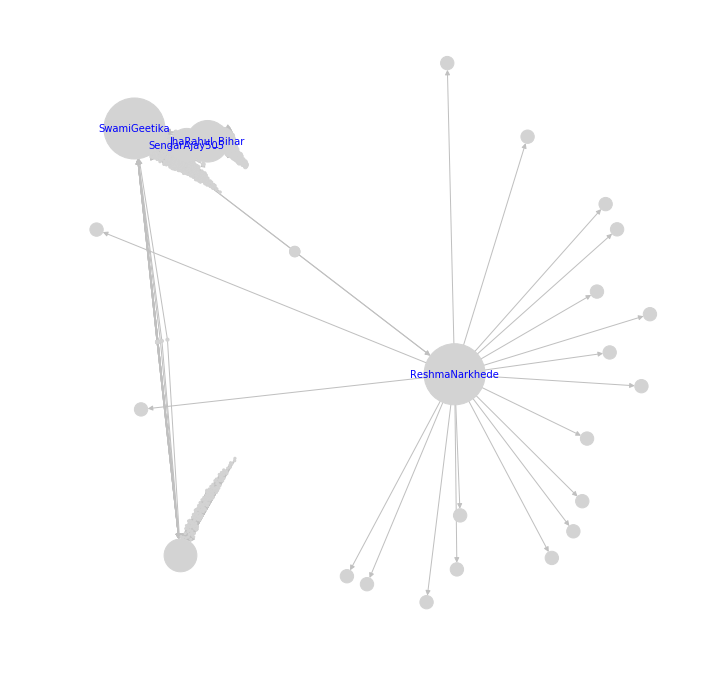

In [252]:
#ti = pd.concat([india_first500.screen_name[:20],india_first500.retweeted_user[:20] ]).unique() 
g = nx.from_pandas_edgelist(india_first500, source='screen_name', target='retweeted_user'
                            ,edge_attr = 'retweets_sent',create_using=nx.DiGraph())
betCent = nx.betweenness_centrality(g, normalized=True, endpoints=True)

ti = sorted(betCent, key=betCent.get, reverse=True)[:4]
labels = {}    

for node in g.nodes():
    if node in list(ti):
        #set the node name as the key and the label as its value 
        labels[node] = node


pos = nx.spring_layout(g)
node_color = [20000.0 * g.degree(v) for v in g]
node_size =  [v * 5e6  for v in betCent.values()]
plt.figure(figsize=(12,12))
nx.draw_networkx(g, pos=pos, 
                 with_labels=None,
                 #with_labels=g.nodes(),
                 #node_color=node_color,
                 node_color='lightgrey',
                 node_size=node_size, edge_color = 'silver' )
nx.draw_networkx_labels(g,labels =labels,pos=pos,font_size=10,font_color='b')
plt.axis('off')
print(nx.info(g))